# Deconstructing the Fitbit Sleep Score

In this project I am going to use different Machine Learning models to try and get a better understanding of how Fitbit computes the sleep score that it provides to its users.

First, I will import some sleep score data and visualise the data in different ways. Afterwards, I will apply Machine Learning Models to the data in order to find, and ultimately be able to predict, patterns.

In [149]:
# Import all relevant libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import statsmodels.api as sm

In [3]:
# Import the sleep data
sleep_score = pd.read_csv('sleep_score.csv')
sleep_stats = pd.read_csv('sleep_stats.csv')

In [6]:
# Inspect the sleep score DataFrame
sleep_score.head()

,timestamp,overall_score,composition_score,revitalization_score,duration_score,deep_sleep_in_minutes,resting_heart_rate,restlessness
0,2020-07-02T06:23:30Z,86,21,22,43,90,59,0.059426
1,2020-07-01T06:03:30Z,77,21,21,35,125,61,0.091463
2,2020-06-30T05:57:00Z,78,20,22,36,79,60,0.058201
3,2020-06-29T06:05:00Z,76,20,22,34,75,61,0.067885
4,2020-06-28T09:20:30Z,82,20,20,42,126,62,0.097103


In [7]:
# Inspect the sleep stats DataFrame
sleep_stats.head()

,Sleep,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8
0,Start Time,End Time,Minutes Asleep,Minutes Awake,Number of Awakenings,Time in Bed,Minutes REM Sleep,Minutes Light Sleep,Minutes Deep Sleep
1,2020-07-01 10:05PM,2020-07-02 6:23AM,456,42,37,498,94,271,91
2,2020-06-30 9:43PM,2020-07-01 6:03AM,412,88,32,500,79,208,125
3,2020-06-29 10:03PM,2020-06-30 5:57AM,412,61,26,473,91,242,79
4,2020-06-28 11:24PM,2020-06-29 6:05AM,342,59,26,401,71,196,75


Something went wrong with the import here. The first row should clearly be the column headers. Let's fix that.

In [11]:
sleep_stats.columns = sleep_stats.iloc[0]
sleep_stat = sleep_stats.drop(sleep_stats.index[0])
sleep_stat

,Start Time,End Time,Minutes Asleep,Minutes Awake,Number of Awakenings,Time in Bed,Minutes REM Sleep,Minutes Light Sleep,Minutes Deep Sleep
1,2020-07-01 10:05PM,2020-07-02 6:23AM,456,42,37,498,94,271,91
2,2020-06-30 9:43PM,2020-07-01 6:03AM,412,88,32,500,79,208,125
3,2020-06-29 10:03PM,2020-06-30 5:57AM,412,61,26,473,91,242,79
4,2020-06-28 11:24PM,2020-06-29 6:05AM,342,59,26,401,71,196,75
5,2020-06-27 10:42PM,2020-06-28 9:20AM,530,108,39,638,98,305,127
...,...,...,...,...,...,...,...,...,...
318,2019-07-12 11:11PM,2019-07-13 7:05AM,423,51,28,474,89,263,71
319,2019-07-11 9:58PM,2019-07-12 8:23AM,540,85,30,625,114,324,102
320,2019-07-10 9:43PM,2019-07-11 7:32AM,525,64,31,589,93,322,110
321,2019-07-09 9:12PM,2019-07-10 7:31AM,536,83,38,619,124,336,76


In [12]:
# Check for NaNs
sleep_score.isna().any(), sleep_stat.isna().any()

(timestamp                False
 overall_score            False
 composition_score        False
 revitalization_score     False
 duration_score           False
 deep_sleep_in_minutes    False
 resting_heart_rate       False
 restlessness             False
 dtype: bool,
 0
 Start Time              False
 End Time                False
 Minutes Asleep          False
 Minutes Awake           False
 Number of Awakenings    False
 Time in Bed             False
 Minutes REM Sleep        True
 Minutes Light Sleep      True
 Minutes Deep Sleep       True
 dtype: bool)

The sleep_stat DataFrame has NaNs and we will drop the rows with missing values.

In [14]:
# Drop rows with missing values
sleep_stat.dropna(axis=0, inplace=True)

I want to be able to merge the two DataFrames on the date. As of now there are slight differences in how the times are displayed. The sleep_stat DataFrame has both starting and ending dates but what we care about are ending dates (those are always the dates on which the sleep score is provided). I will drop the beginning date column, transform the dates so that they are in the same format across the two DataFrames and then merge the DataFrames on the date.

In [ ]:
# Drop start time column from sleep_stat
sleep_stat.drop(columns='Start Time', inplace=True)

In [22]:
# Separate date into new column
sleep_stat['Date'] = sleep_stat['End Time'].apply(lambda x: x[:10])
sleep_score['Date'] = sleep_score.timestamp.apply(lambda x: x[:10])

In [24]:
# Merge the two DataFrames
joined_sleep = sleep_stat.merge(sleep_score, on='Date', how='left')
joined_sleep.head()

,End Time,Minutes Asleep,Minutes Awake,Number of Awakenings,Time in Bed,Minutes REM Sleep,Minutes Light Sleep,Minutes Deep Sleep,Date,timestamp,overall_score,composition_score,revitalization_score,duration_score,deep_sleep_in_minutes,resting_heart_rate,restlessness
0,2020-07-02 6:23AM,456,42,37,498,94,271,91,2020-07-02,2020-07-02T06:23:30Z,86.0,21.0,22.0,43.0,90.0,59.0,0.059426
1,2020-07-01 6:03AM,412,88,32,500,79,208,125,2020-07-01,2020-07-01T06:03:30Z,77.0,21.0,21.0,35.0,125.0,61.0,0.091463
2,2020-06-30 5:57AM,412,61,26,473,91,242,79,2020-06-30,2020-06-30T05:57:00Z,78.0,20.0,22.0,36.0,79.0,60.0,0.058201
3,2020-06-29 6:05AM,342,59,26,401,71,196,75,2020-06-29,2020-06-29T06:05:00Z,76.0,20.0,22.0,34.0,75.0,61.0,0.067885
4,2020-06-28 9:20AM,530,108,39,638,98,305,127,2020-06-28,2020-06-28T09:20:30Z,82.0,20.0,20.0,42.0,126.0,62.0,0.097103


In order to get this merged DataFrame in an order that I prefer, I will drop the End Time and the timestamp column and rearrange the columns so that the Date is the first column.

In [33]:
# Drop redundant columns
sleep_data = joined_sleep.drop(columns=['End Time', 'timestamp'])

In [34]:
# Get a list of the columns
cols = sleep_data.columns.tolist()
cols

['Minutes Asleep',
 'Minutes Awake',
 'Number of Awakenings',
 'Time in Bed',
 'Minutes REM Sleep',
 'Minutes Light Sleep',
 'Minutes Deep Sleep',
 'Date',
 'overall_score',
 'composition_score',
 'revitalization_score',
 'duration_score',
 'deep_sleep_in_minutes',
 'resting_heart_rate',
 'restlessness']

In [35]:
# Rearrange the columns
new_cols = [cols[7]] + cols[:7] + cols[8:]
new_cols

['Date',
 'Minutes Asleep',
 'Minutes Awake',
 'Number of Awakenings',
 'Time in Bed',
 'Minutes REM Sleep',
 'Minutes Light Sleep',
 'Minutes Deep Sleep',
 'overall_score',
 'composition_score',
 'revitalization_score',
 'duration_score',
 'deep_sleep_in_minutes',
 'resting_heart_rate',
 'restlessness']

In [43]:
# Reorder the DataFrame
sleep_new = sleep_data[new_cols]
sleep_new.head()

,Date,Minutes Asleep,Minutes Awake,Number of Awakenings,Time in Bed,Minutes REM Sleep,Minutes Light Sleep,Minutes Deep Sleep,overall_score,composition_score,revitalization_score,duration_score,deep_sleep_in_minutes,resting_heart_rate,restlessness
0,2020-07-02,456,42,37,498,94,271,91,86.0,21.0,22.0,43.0,90.0,59.0,0.059426
1,2020-07-01,412,88,32,500,79,208,125,77.0,21.0,21.0,35.0,125.0,61.0,0.091463
2,2020-06-30,412,61,26,473,91,242,79,78.0,20.0,22.0,36.0,79.0,60.0,0.058201
3,2020-06-29,342,59,26,401,71,196,75,76.0,20.0,22.0,34.0,75.0,61.0,0.067885
4,2020-06-28,530,108,39,638,98,305,127,82.0,20.0,20.0,42.0,126.0,62.0,0.097103


In [47]:
# Drop the one row with remaining NaNs
sleep = sleep_new.dropna(axis=0)

Before I continue with some statistics and Machine Learning I want to visualise the data.

In [62]:
# Find spread of sleep score values
spread = int(max(sleep.overall_score) - min(sleep.overall_score))
spread

32

Text(0.5, 1.0, 'Sleep Score Distribution')

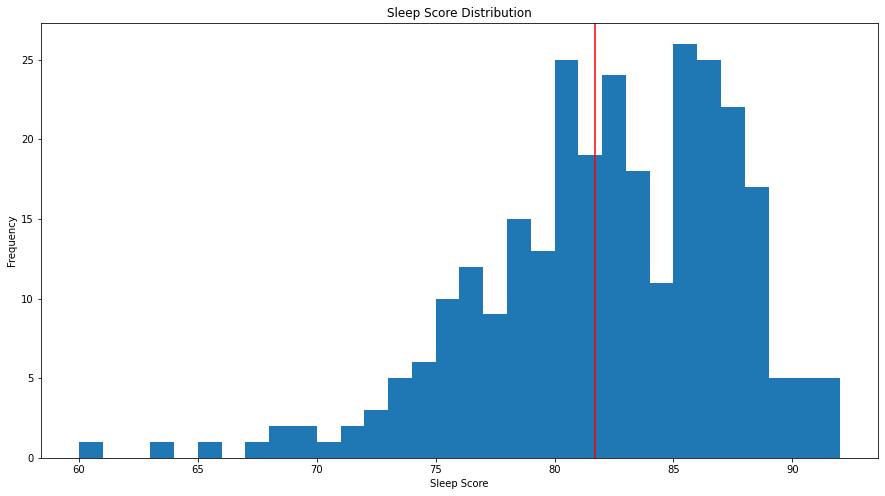

In [63]:
# Plot sleep score histogram
plt.figure(figsize=(15,8))
plt.hist(sleep.overall_score, bins=spread)
plt.axvline(sleep.overall_score.mean(), color='r', label='Average Sleep Score')
plt.xlabel('Sleep Score')
plt.ylabel('Frequency')
plt.title('Sleep Score Distribution')

It appears as though the sleep scores have a multimodal (almost bimodal) distribution and are skewed to the left. Next, I want to have a look at the time series of the sleep scores and the components provided in the Fitbit App. Because the Fitbit App gives you both percentages and absolute values I will compute the percentages of sleep stages and being awake first. I will focus on time in bed and minutes spend in each sleep stage in this part of the analysis.

In [85]:
# Create DataFrame that represents what the App provides to users
app_cols = sleep.columns[:9]
app_cols

Index(['Date', 'Minutes Asleep', 'Minutes Awake', 'Number of Awakenings',
       'Time in Bed', 'Minutes REM Sleep', 'Minutes Light Sleep',
       'Minutes Deep Sleep', 'overall_score'],
      dtype='object')

In [107]:
# Create a DataFrame with these columns
app_data = sleep[app_cols]
app_data.head()

,Date,Minutes Asleep,Minutes Awake,Number of Awakenings,Time in Bed,Minutes REM Sleep,Minutes Light Sleep,Minutes Deep Sleep,overall_score
0,2020-07-02,456,42,37,498,94,271,91,86.0
1,2020-07-01,412,88,32,500,79,208,125,77.0
2,2020-06-30,412,61,26,473,91,242,79,78.0
3,2020-06-29,342,59,26,401,71,196,75,76.0
4,2020-06-28,530,108,39,638,98,305,127,82.0


In [110]:
# Convert columns to floats
app_data[app_cols[1:8]] = app_data[app_cols[1:8]].astype(float)
app_data.head()

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,Date,Minutes Asleep,Minutes Awake,Number of Awakenings,Time in Bed,Minutes REM Sleep,Minutes Light Sleep,Minutes Deep Sleep,overall_score
0,2020-07-02,456.0,42.0,37.0,498.0,94.0,271.0,91.0,86.0
1,2020-07-01,412.0,88.0,32.0,500.0,79.0,208.0,125.0,77.0
2,2020-06-30,412.0,61.0,26.0,473.0,91.0,242.0,79.0,78.0
3,2020-06-29,342.0,59.0,26.0,401.0,71.0,196.0,75.0,76.0
4,2020-06-28,530.0,108.0,39.0,638.0,98.0,305.0,127.0,82.0


In [121]:
# Let's have a quick look at the correlations between these
app_data[app_cols[1:]].corr()

,Minutes Asleep,Minutes Awake,Number of Awakenings,Time in Bed,Minutes REM Sleep,Minutes Light Sleep,Minutes Deep Sleep,overall_score
Minutes Asleep,1.000000,0.489912,0.715422,0.980407,0.629681,0.756920,0.511837,0.699627
Minutes Awake,0.489912,1.000000,0.360927,0.652037,0.160597,0.428132,0.303564,0.033523
Number of Awakenings,0.715422,0.360927,1.000000,0.703762,0.403212,0.528979,0.446308,0.527397
Time in Bed,0.980407,0.652037,0.703762,1.000000,0.583927,0.755038,0.513741,0.616046
Minutes REM Sleep,0.629681,0.160597,0.403212,0.583927,1.000000,0.083341,0.433558,0.745308
Minutes Light Sleep,0.756920,0.428132,0.528979,0.755038,0.083341,1.000000,-0.035149,0.287346
Minutes Deep Sleep,0.511837,0.303564,0.446308,0.513741,0.433558,-0.035149,1.000000,0.503672
overall_score,0.699627,0.033523,0.527397,0.616046,0.745308,0.287346,0.503672,1.000000


The sleep score has the highest correlation with Minutes REM sleep. This could be an early inidcator of the importance of REM sleep. Furthermore, and this is important, there are patterns of high correlation between independent variables, i.e. everything that is not the overall score. This could cause issues in statistical modeling and should be handled before running any models.

One common way of testing for multicollinearity is to use Variable Inflation Factors (VIF). VIF essentially tests how strong the correlation between independent variables is by regressing every independent variable against all other independent variables. The VIF is inflated by R^2, meaning that a higher R^2 (which indicates high correlation) increases the VIF.

In [124]:
# Define a function to calculate the VIF
def calc_vif(X):
    # Create a DataFrame for the VIFs
    vif = pd.DataFrame()
    vif['Variable'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    
    return vif

In [134]:
# Separate the independent variables
X1 = app_data.iloc[:,1:-1]

In [135]:
# Calculate the VIFs
calc_vif(X1)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,Variable,VIF
0,Minutes Asleep,inf
1,Minutes Awake,inf
2,Number of Awakenings,63.181782
3,Time in Bed,inf
4,Minutes REM Sleep,inf
5,Minutes Light Sleep,inf
6,Minutes Deep Sleep,inf


As some of the values are clearly almost perfectly correlated, i.e. they can be perfectly explained by some or all other independent variables, the VIF is infinity for every independent variable apart from Number of Awakenings. 

If we think about it this makes perfect sense. Minutes Asleep, for example, can be computed as the sum of the minutes spent in REM, Light and Deep Sleep and vice versa. The only independent variable that can't be perfectly explained by the others is Number of Awakenings. This is still highly correlated with the other independent variables though. Let's start removing independent variables and recaluclating the VIF.

In [140]:
# Drop Minutes Asleep and recaluclate VIFs
X2 = X1.drop(columns=['Minutes Asleep', 'Minutes Light Sleep', 'Time in Bed', 'Minutes Deep Sleep', 'Number of Awakenings'])
calc_vif(X2)

,Variable,VIF
0,Minutes Awake,10.775362
1,Minutes REM Sleep,10.775362


Just out of curiosity, I want to do the same with percentage times.

In [143]:
# Create DataFrame
app_data_pc = pd.DataFrame()

# Create percentage columns and keep the total time in bed
app_data_pc['Time in Bed'] = app_data['Time in Bed']
app_data_pc['% Awake'] = round(app_data['Minutes Awake'] / app_data['Time in Bed'], 2)
app_data_pc['% REM'] = round(app_data['Minutes REM Sleep'] / app_data['Time in Bed'], 2)
app_data_pc['% Light'] = round(app_data['Minutes Light Sleep'] / app_data['Time in Bed'], 2)
app_data_pc['% Deep'] = round(app_data['Minutes Deep Sleep'] / app_data['Time in Bed'], 2)

app_data_pc.head()

,Time in Bed,% Awake,% REM,% Light,% Deep
0,498.0,0.08,0.19,0.54,0.18
1,500.0,0.18,0.16,0.42,0.25
2,473.0,0.13,0.19,0.51,0.17
3,401.0,0.15,0.18,0.49,0.19
4,638.0,0.17,0.15,0.48,0.20


In [144]:
# Calculate the VIF
calc_vif(app_data_pc)

,Variable,VIF
0,Time in Bed,59.958105
1,% Awake,30.548409
2,% REM,22.231293
3,% Light,37.951094
4,% Deep,23.041844


In [147]:
# Drop Light Sleep and recalculate
app_data_pc_reduced = app_data_pc.drop(columns='% Light')
calc_vif(app_data_pc_reduced)

,Variable,VIF
0,Time in Bed,43.068105
1,% Awake,26.505426
2,% REM,22.225678
3,% Deep,23.034142


Let's now run a Multiple Linear Regression using the four independent variables. First, store the variables as X and y, respectively.

In [148]:
# Store x-values
X = app_data_pc_reduced

# Store y-values
y = app_data['overall_score']

In [ ]:
# Train and run regression